<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-NEB-end-structures" data-toc-modified-id="Prepare-NEB-end-structures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare NEB end structures</a></span><ul class="toc-item"><li><span><a href="#Download-from-Materials-Project-and-create-supercell" data-toc-modified-id="Download-from-Materials-Project-and-create-supercell-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download from Materials Project and create supercell</a></span></li><li><span><a href="#Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span></li><li><span><a href="#Create-and-relax-NEB-end-structures----b-and-c-directions" data-toc-modified-id="Create-and-relax-NEB-end-structures----b-and-c-directions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create and relax NEB end structures -- b and c directions</a></span></li></ul></li><li><span><a href="#NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span><ul class="toc-item"><li><span><a href="#generate-NEB-images-from-end-structures-and-conduct-NEB" data-toc-modified-id="generate-NEB-images-from-end-structures-and-conduct-NEB-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate NEB images from end structures and conduct NEB</a></span></li><li><span><a href="#analyze-and-plot-NEB-results" data-toc-modified-id="analyze-and-plot-NEB-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>analyze and plot NEB results</a></span></li><li><span><a href="#Store-NEB-images-in-one-cif-file-for-visualization" data-toc-modified-id="Store-NEB-images-in-one-cif-file-for-visualization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Store NEB images in one cif file for visualization</a></span></li><li><span><a href="#Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)" data-toc-modified-id="Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize NEB path (snapshots of VESTA visualization of path_final.cif)</a></span></li></ul></li></ul></div>


DFT barrier heights: path b = 0.27 eV and path c = 2.5 eV. (see table 1 in https://doi.org/10.1039/C5TA05062F)


In [ ]:
from __future__ import annotations

import os

from ase.mep import NEBTools
from pymatgen.ext.matproj import MPRester

from matcalc import NEBCalc, RelaxCalc, load_up

mpr = MPRester()

data_dir = "NEB_data"
os.makedirs(data_dir, exist_ok=True)

# Prepare NEB end structures


## Download from Materials Project and create supercell


In [ ]:
s_LFPO = mpr.get_structure_by_material_id("mp-19017")
s_LFPO.make_supercell([1, 2, 2], in_place=True)
s_LFPO.to(f"{data_dir}/LiFePO4_supercell.cif", "cif")
s_LFPO.lattice.abc, s_LFPO.formula

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

((10.23619605, 11.941510200000154, 9.309834380000202), 'Li16 Fe16 P16 O64')

## Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet


In [ ]:
model = load_up("M3GNet-MP-2021.2.8-DIRECT-PES")

In [ ]:
%%time
relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=True, fmax=0.02)
supercell_LFPO_relaxed = relaxer.calc(s_LFPO)["final_structure"]
results = {"supercell_LFPO": supercell_LFPO_relaxed}

CPU times: user 2min 10s, sys: 4min 14s, total: 6min 25s
Wall time: 53.7 s


## Create and relax NEB end structures -- b and c directions


In [ ]:
%%time
relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=False, fmax=0.02)
supercell_LFPO_relaxed = results["supercell_LFPO"]

# NEB path along b and c directions have the same starting image.
s_LFPO_end_b = supercell_LFPO_relaxed.copy()
s_LFPO_end_b.remove_sites([11])
s_LFPO_end_b_relaxed = relaxer.calc(s_LFPO_end_b)["final_structure"]
s_LFPO_end_c = supercell_LFPO_relaxed.copy()
s_LFPO_end_c.remove_sites([4])
s_LFPO_end_c_relaxed = relaxer.calc(s_LFPO_end_c)["final_structure"]
s_LFPO_start_bc = supercell_LFPO_relaxed.copy()
s_LFPO_start_bc.remove_sites([5])
s_LFPO_start_bc_relaxed = relaxer.calc(s_LFPO_start_bc)["final_structure"]
results.update(
    {
        "supercell_LFPO_end_b": s_LFPO_end_b_relaxed,
        "supercell_LFPO_end_c": s_LFPO_end_c_relaxed,
        "supercell_LFPO_start_bc": s_LFPO_start_bc_relaxed,
    }
)

CPU times: user 1min 59s, sys: 4min 45s, total: 6min 44s
Wall time: 52 s


## Generate NEB images from end structures and conduct NEB


In [ ]:
%%time

for neb_path in "bc":
    neb_calc = NEBCalc(
        calculator=model,
        optimizer="BFGS",  # Specify the optimizer if different from default
        traj_folder=f"{data_dir}/traj_{neb_path}/",
        climb=True,
        fmax=0.05,
        max_steps=1000,  # Specify max_steps if different from default
    )
    # Instantiate the NEBCalc object with the desired parameters

    results_dict = neb_calc.calc_images(
        start_struct=results["supercell_LFPO_start_bc"],
        end_struct=results[f"supercell_LFPO_end_{neb_path}"],
        n_images=7,
        interpolate_lattices=False,
        autosort_tol=0.5,
    )

    barrier = results_dict["barrier"]
    results[f"mep_{neb_path}"] = results_dict["mep"]
    results[f"NEB_{neb_path}"] = neb_calc.neb
    print(f"Barrier along {neb_path}: {barrier} eV.")

/Users/shyue/repos/matcalc/src/matcalc/_neb.py:120: FutureWarning: Please import NEB from ase.mep, not ase.neb.
  self.neb = NEB(images, climb=self.climb, allow_shared_calculator=True, **self.kwargs)


      Step     Time          Energy          fmax
BFGS:    0 17:57:29     -756.272156        1.810983
BFGS:    1 17:57:42     -756.389709        1.203475
BFGS:    2 17:57:57     -756.550842        0.739199
BFGS:    3 17:58:11     -756.629150        0.545949
BFGS:    4 17:58:23     -756.659912        0.467876
BFGS:    5 17:58:36     -756.669128        0.463015
BFGS:    6 17:58:51     -756.680847        0.449014
BFGS:    7 17:59:09     -756.698608        0.430838
BFGS:    8 17:59:22     -756.719604        0.316095
BFGS:    9 17:59:37     -756.733032        0.303286
BFGS:   10 17:59:53     -756.739502        0.311070
BFGS:   11 18:00:07     -756.748108        0.312358
BFGS:   12 18:00:21     -756.758728        0.260717
BFGS:   13 18:00:34     -756.772278        0.282615
BFGS:   14 18:00:49     -756.785645        0.268146
BFGS:   15 18:01:02     -756.793396        0.233269
BFGS:   16 18:01:15     -756.798157        0.224495
BFGS:   17 18:01:27     -756.803467        0.180113
BFGS:   18 18:

/Users/shyue/repos/matcalc/src/matcalc/_neb.py:131: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.
  neb_tool = NEBTools(self.neb.images)


Barrier along b: 0.15710449218749956 eV.
      Step     Time          Energy          fmax
BFGS:    0 18:06:30     -755.307739        4.680775
BFGS:    1 18:06:43     -755.582764        1.755719
BFGS:    2 18:06:58     -755.707825        1.327105
BFGS:    3 18:07:12     -755.897095        0.831627
BFGS:    4 18:07:25     -755.949829        0.620606
BFGS:    5 18:07:40     -755.974854        0.663567
BFGS:    6 18:07:55     -755.987732        0.544448
BFGS:    7 18:08:09     -756.006104        0.421952
BFGS:    8 18:08:23     -756.031433        0.284905
BFGS:    9 18:08:42     -756.050537        0.261008
BFGS:   10 18:09:03     -756.059448        0.312527
BFGS:   11 18:09:17     -756.063965        0.284364
BFGS:   12 18:09:28     -756.067078        0.238303
BFGS:   13 18:09:42     -756.071777        0.184337
BFGS:   14 18:09:55     -756.077759        0.125851
BFGS:   15 18:10:08     -756.081299        0.133164
BFGS:   16 18:10:20     -756.083496        0.115811
BFGS:   17 18:10:34     -

## Analyze and plot NEB results

Path along b: 


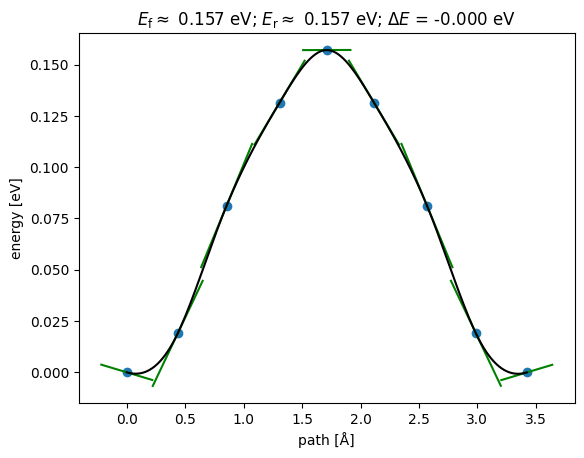

Path along c: 


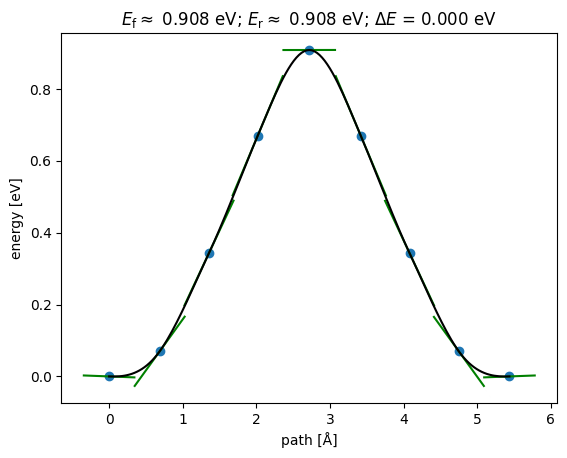

CPU times: user 30.4 s, sys: 1min 47s, total: 2min 18s
Wall time: 18.2 s


In [ ]:
%%time
import matplotlib.pyplot as plt

for neb_path in "bc":
    NEB_tool = NEBTools(results[f"NEB_{neb_path}"].images)
    print(f"Path along {neb_path}: ")
    fig = NEB_tool.plot_band()
    plt.show()

## Store NEB images in one cif file for visualization


In [ ]:
from itertools import chain

from pymatgen.core import PeriodicSite, Structure
from pymatgen.io.ase import AseAtomsAdaptor


def generate_path_cif_from_images(images: list, filename: str) -> None:
    """Generate a cif file from a list of image atoms."""
    image_structs = [AseAtomsAdaptor.get_structure(image) for image in images]
    sites = set()
    lattice = image_structs[0].lattice
    sites.update(
        PeriodicSite(site.species, site.frac_coords, lattice) for site in chain(*(struct for struct in image_structs))
    )
    neb_path = Structure.from_sites(sorted(sites))
    neb_path.to(filename, "cif")

In [ ]:
%%time
for neb_path in "bc":
    NEB_tool = NEBTools(results[f"NEB_{neb_path}"].images)
    generate_path_cif_from_images(NEB_tool.images, f"{data_dir}/traj_{neb_path}/path_final.cif")

CPU times: user 6.49 s, sys: 1.12 s, total: 7.61 s
Wall time: 5.61 s


In [ ]:
# Perform some cleanup.

import shutil

shutil.rmtree(data_dir)